In [19]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pprint
from cohorts.functions import missense_snv_count
import lifelines as ll
import patsy
import functools
import survivalstan
from stancache import stancache, config
import os
from cohorts.utils import strip_column_names
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sample_file_dir = '/mnt/checkpoint-trials/bladder/stan_sample_files'
config.set_value(CACHE_DIR='/mnt/checkpoint-trials/bladder/stancache')

INFO:root:Setting CACHE_DIR = /mnt/checkpoint-trials/bladder/stancache


In [3]:
## set seeds for stan & rngs, to aid in reproducibility
## (note: only reproducible within a machine, not across machines)

seed = 91038753
import random
random.seed(seed)

In [4]:
from utils import data
from utils import paper
from utils.extra_functions import *


# prep data 

## load data

In [5]:
cohort = data.init_cohort(join_with=["ensembl_coverage","tcr_peripheral_a"])

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
{'dataframe_hash': -7522244498661454348,
 'provenance_file_summary': {u'cohorts': u'0.4.2',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.1',
                             u'numpy': u'1.11.2',
                             u'pandas': u'0.19.2',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.11'}}


In [6]:
def tcell_fraction(row):
    return row["T-cell fraction"]

def peripheral_clonality_a(row):
    return row['Clonality']

cols, d = cohort.as_dataframe([missense_snv_count,
                               peripheral_clonality_a,
                               tcell_fraction,
                               ],
                              rename_cols=True,
                              return_cols=True)

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/jacquelineburos/.cache/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


inner join with ensembl_coverage: 25 to 25 rows


In [7]:
cols

['missense_snv_count', 'peripheral_clonality_a', 'tcell_fraction']

In [8]:
# confirm benefit & benefit-os names
print(cohort.benefit_plot_name)

DCB


## construct/rescale variables

In [9]:
## create 'observed', log-transformed & centered versions of variables (not normalized by MB)
for col in cols:
    observed_col = 'observed_{}'.format(col)
    log_col = 'log_{}'.format(col)
    log_col_centered = 'log_{}_centered'.format(col)
    log_col_rescaled = 'log_{}_rescaled'.format(col)
    d[observed_col] = d[col]*d['mb']
    d[log_col] = np.log1p(d[observed_col])
    d[log_col_centered] = d[log_col] - np.mean(d[log_col])
    d[log_col_rescaled] = d[log_col_centered]/np.std(d[log_col_centered])

## save key vars in list for future use
vars_centered = ['log_{}_centered'.format(col) for col in cols]
vars_rescaled = ['log_{}_rescaled'.format(col) for col in cols]

## center variables by mean within PD-L1 group

In [10]:
## identify list of variables to center
metrics = list(cols)


In [11]:
metrics2 = list(metrics)
metrics2.extend(['pd_l1'])
assert(not 'pd_l1' in metrics)
log_metrics2 = ['log_{}'.format(var) for var in metrics2]
metrics2.extend(log_metrics2)

In [12]:
grp_metrics = [var for var in metrics2 if var in d.columns]

In [13]:
# center variables by group
bygrp = d.loc[:, grp_metrics]
bygrp = bygrp.groupby('pd_l1').transform(lambda x: x - x.mean())
bygrp['patient_id'] = d.patient_id

In [14]:
# merge recentered variables back into original dataframe
df = pd.merge(d, bygrp, on = 'patient_id', suffixes = ['', '_centered_by_pd_l1'])

# prep survival data in long format

In [15]:
## prep dflong_pfs which will be used for survival analysis using stan
df_long_pfs = survivalstan.prep_data_long_surv(df = df,
                                               event_col = 'is_progressed_or_deceased',
                                               time_col = 'pfs')
df_long_os = survivalstan.prep_data_long_surv(df = df,
                                               event_col = 'is_deceased',
                                               time_col = 'os')


# multivariate analysis using varying-coef model

In [16]:
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline2.stan
../utils/stan/pem_survival_model_randomwalk2.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_randomwalk_bspline.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan


In [17]:
survstan_pfs_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    FIT_FUN = stancache.cached_stan_fit,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    control=dict(adapt_delta=0.9)
    )
survstan_os_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_os,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    FIT_FUN = stancache.cached_stan_fit,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    control=dict(adapt_delta=0.9)
    )


## varying-coef model for peripheral TCR clonality at timepoint A by pd-l1

In [20]:
tcrclonality_by_pdl1 = survstan_pfs_varcoef(formula = 'log_peripheral_clonality_a_centered_by_pd_l1', 
                                            group_col = 'pd_l1',
                                            sample_file = os.path.join(sample_file_dir, 'tcr_clonality_X_pdl1'),
                                            model_cohort = 'tcr_clonality_X_pd_l1'
                                            )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_9571340839314917516.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_9571340839314917516.pystan_2_14_0_0.stanfit.chains_4.control_81717217759.data_55819852896.iter_10000.sample_file_1080157740070054779.seed_91038753.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:03:48.462343 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/home/jacquelineburos/miniconda3/envs/newbladder2/lib/python2.7/pickle.py:306: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along

In [21]:
survivalstan.utils.print_stan_summary([tcrclonality_by_pdl1], pars='lp__')

           mean   se_mean        sd      2.5%        50%      97.5%      Rhat
lp__ -66.154676  1.086609  19.19334 -94.51629 -69.873692 -16.616185  1.024204


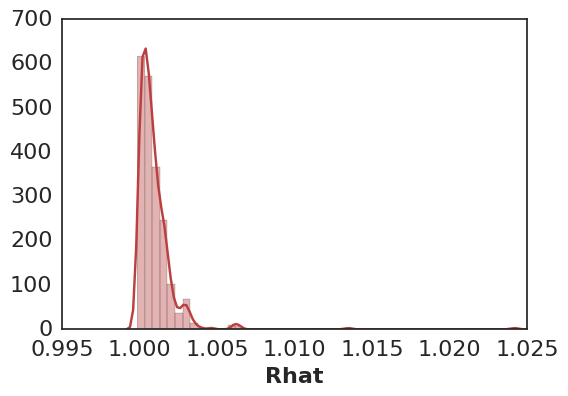

In [22]:
survivalstan.utils.plot_stan_summary([tcrclonality_by_pdl1], metric='Rhat')

{{{tcrclonality_by_pdl1_pfs}}}


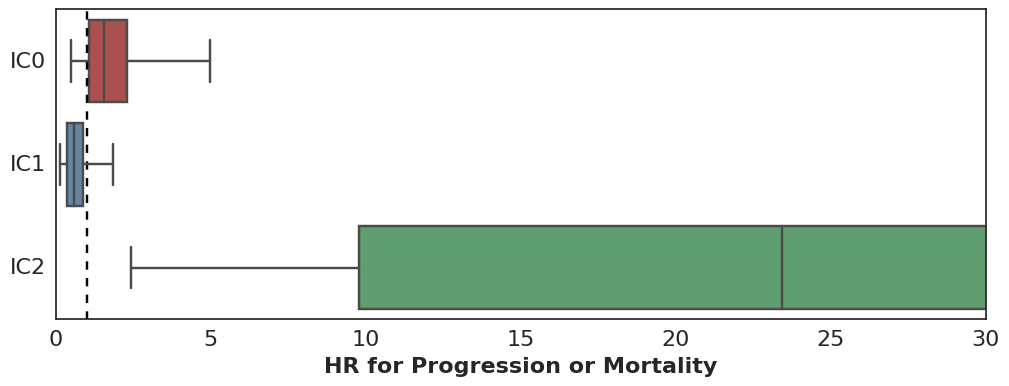

In [23]:
## capture current figure size
paper.hyper_figure_label_printer('tcrclonality_by_pdl1_pfs')
## make this plot much wider than usual
current_fig_size = plt.rcParams["figure.figsize"]
new_fig_size = [current_fig_size[0]*2, current_fig_size[1]]
plt.rcParams["figure.figsize"] = new_fig_size
## plot
sb.boxplot(data=tcrclonality_by_pdl1['grp_coefs'], x='exp(beta)', y='group', fliersize=0, whis=[2.5, 97.5])
_ = plt.xlim([0, 30])
_ = plt.vlines(1, -10, 10, linestyles='--')
#_ = plt.title('Hazard associated with log(Peripheral clonality at timepoint A) \n by level of intratumoral PD-L1 expression')
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))
## revert width to original size
plt.rcParams["figure.figsize"] = current_fig_size

{{{tcrclonality_by_pdl1_pfs_split}}}


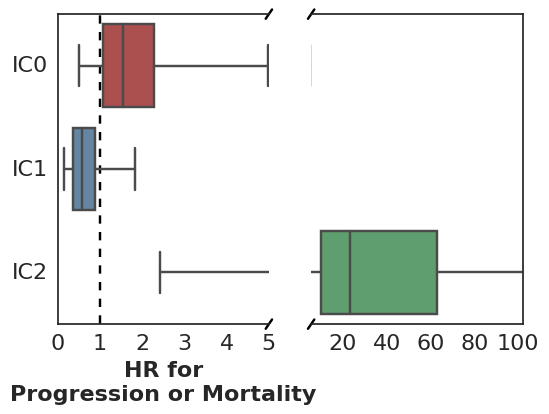

In [24]:
paper.hyper_figure_label_printer('tcrclonality_by_pdl1_pfs_split')
## plot side-by-side zoomed & unzoomed plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sb.boxplot(data=tcrclonality_by_pdl1['grp_coefs'],
           x='exp(beta)',
           y='group',
           fliersize=0,
           whis=[2.5, 97.5], 
           ax=ax1,
          )
ax1.set_xlim([0, 5.])
ax1.set_ylabel('')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax1.set_yticklabels([0,1,2],['','',''])
#ax1.vlines(1, -10, 10, linestyles='--')
#ax1.set_yticks([0])
#ax1.get_yaxis().set_visible(False)

sb.boxplot(data=tcrclonality_by_pdl1['grp_coefs'],
           x='exp(beta)',
           y='group',
           fliersize=0,
           whis=[2.5, 97.5],
           ax=ax2,
          )
ax2.set_xlim([5.5, 102])
ax2.set_ylabel('')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-right diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal

ax1.vlines(1, -10, 10, linestyles='--')
ax1.set_xlabel('HR for\n{}'.format(cohort.hazard_plot_name))
ax2.set_xlabel('')
## rotate labels on x axis
#_ = plt.setp(ax1.get_xticklabels(), rotation='vertical')
#_ = plt.setp(ax2.get_xticklabels(), rotation='vertical')

In [25]:
## summarize results by IC group
tcrclonality_by_pdl1['grp_coefs']['group_label'] = tcrclonality_by_pdl1['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_among_{}'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl1['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary='mean',
                              series=group['exp(beta)'])

{{{hr_clonality_pfs_among_IC0:n=4, HR=1.86, 95% CI (0.50, 4.99)}}}
{{{hr_clonality_pfs_among_IC1:n=11, HR=0.69, 95% CI (0.15, 1.84)}}}
{{{hr_clonality_pfs_among_IC2:n=10, HR=89.88, 95% CI (2.43, 506.94)}}}


In [26]:
## confirm what HR would look like if summarized using the median
tcrclonality_by_pdl1['grp_coefs']['group_label'] = tcrclonality_by_pdl1['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_among_{}_median'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl1['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary='median',
                              series=group['exp(beta)'])

{{{hr_clonality_pfs_among_IC0_median:n=4, HR=1.55, 95% CI (0.50, 4.99)}}}
{{{hr_clonality_pfs_among_IC1_median:n=11, HR=0.58, 95% CI (0.15, 1.84)}}}
{{{hr_clonality_pfs_among_IC2_median:n=10, HR=23.41, 95% CI (2.43, 506.94)}}}


In [27]:
## summarize results by IC group
tcrclonality_by_pdl1['grp_coefs']['group_label'] = tcrclonality_by_pdl1['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_among_{}_both'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl1['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary=['mean','median'],
                              series=group['exp(beta)'])

{{{hr_clonality_pfs_among_IC0_both:n=4, HR (mean)=1.86, HR (median)=1.55, 95% CI (0.50, 4.99)}}}
{{{hr_clonality_pfs_among_IC1_both:n=11, HR (mean)=0.69, HR (median)=0.58, 95% CI (0.15, 1.84)}}}
{{{hr_clonality_pfs_among_IC2_both:n=10, HR (mean)=89.88, HR (median)=23.41, 95% CI (2.43, 506.94)}}}


In [28]:
## summarize results by IC group
tcrclonality_by_pdl1['grp_coefs']['group_label'] = tcrclonality_by_pdl1['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_among_{}_both_with_p'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl1['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary=['mean','median'],
                              series=group['exp(beta)'],
                              include_p=True, p_compare=1)

{{{hr_clonality_pfs_among_IC0_both_with_p:n=4, HR (mean)=1.86, HR (median)=1.55, 95% CI (0.50, 4.99), p(HR>1)=0.21}}}
{{{hr_clonality_pfs_among_IC1_both_with_p:n=11, HR (mean)=0.69, HR (median)=0.58, 95% CI (0.15, 1.84), p(HR<1)=0.19}}}
{{{hr_clonality_pfs_among_IC2_both_with_p:n=10, HR (mean)=89.88, HR (median)=23.41, 95% CI (2.43, 506.94), p(HR>1)=0.0014}}}


In [29]:
## bayesian p-value for interaction
comparison3 = pd.pivot_table(tcrclonality_by_pdl1['grp_coefs'],
                  index = ['iter', 'model_cohort', 'variable'],
                  values = 'value', columns = 'group')
print('{{{%s:%s}}}' % ('pval_clonality_pfs_interaction', paper.float_str(1-(comparison3.eval('IC0 < IC2').mean()))))

{{{pval_clonality_pfs_interaction:0.018}}}


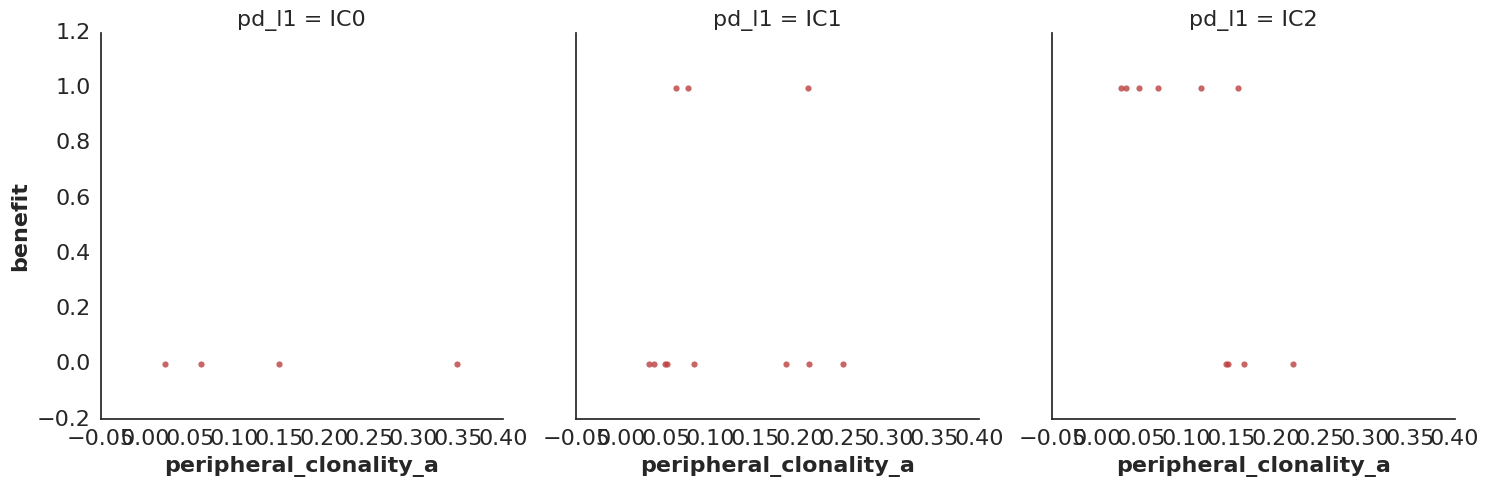

In [30]:
# inspect raw data - are results reasonable?
sb.lmplot(data = df, x = 'peripheral_clonality_a', y = 'benefit', col='pd_l1', logistic=True, fit_reg=False)

In [31]:
coefdata = tcrclonality_by_pdl1['grp_coefs']
pval = (1-np.mean(coefdata.loc[coefdata['group']=='IC2','value'] >= 0))
print('{{{%s:%s}}}' % ('pval_clonality_pfs_interaction_ic2',
                       paper.float_str(pval)))

{{{pval_clonality_pfs_interaction_ic2:0.0014}}}


## try with horseshoe prior on beta coefs

In [32]:
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline2.stan
../utils/stan/pem_survival_model_randomwalk2.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_randomwalk_bspline.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan


In [33]:
survstan_pfs_varcoef2 = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef_hsprior.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    FIT_FUN = stancache.cached_stan_fit,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    stan_data = {'nu': 1} 
    )

In [34]:
tcrclonality_by_pdl12 = survstan_pfs_varcoef2(formula = 'log_peripheral_clonality_a_centered_by_pd_l1', 
                                              group_col = 'pd_l1',
                                              sample_file = os.path.join(sample_file_dir, 'log_clonality_centered_X_pd_l1')
                                              )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_6577752496410395669.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c3377bc1a36c09afabf5116838435a79 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:01:04.083157 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_6577752496410395669.pystan_2_14_0_0.stanfit.chains_4.data_22651645239.iter_10000.sample_file_17974228969897673448.seed_91038753.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:08:42.949475 elapsed)
INFO:stancache.stancache:sampling: Saving re

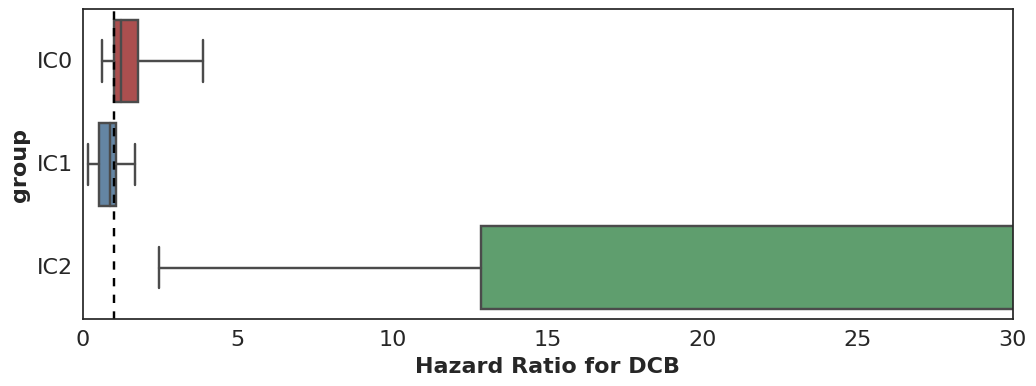

In [35]:
#paper.hyper_figure_label_printer('hr_tcrclonality_by_pdl1_pfs')
current_fig_size = plt.rcParams["figure.figsize"]
new_fig_size = [current_fig_size[0]*2, current_fig_size[1]]
plt.rcParams["figure.figsize"] = new_fig_size
## plot
sb.boxplot(data=tcrclonality_by_pdl12['grp_coefs'], x='exp(beta)', y='group', fliersize=0, whis=[2.5, 97.5])
_ = plt.xlim([0, 30])
_ = plt.vlines(1, -10, 10, linestyles='--')
#_ = plt.title('Hazard associated with log(Peripheral clonality at timepoint A) \n by level of intratumoral PD-L1 expression')
_ = plt.xlabel('Hazard Ratio for {}'.format(cohort.benefit_plot_name))
## revert width to original size
plt.rcParams["figure.figsize"] = current_fig_size

In [36]:
tcrclonality_by_pdl12['grp_coefs']['group_label'] = tcrclonality_by_pdl12['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_hsprior_among_{}'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl12['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              series=group['exp(beta)'])

{{{hr_clonality_pfs_hsprior_among_IC0:n=4, HR=1.53, 95% CI (0.61, 3.87)}}}
{{{hr_clonality_pfs_hsprior_among_IC1:n=11, HR=0.84, 95% CI (0.18, 1.67)}}}
{{{hr_clonality_pfs_hsprior_among_IC2:n=10, HR=111.55, 95% CI (2.45, 660.72)}}}


In [37]:
tcrclonality_by_pdl12['grp_coefs']['group_label'] = tcrclonality_by_pdl12['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_hsprior_among_{}_median'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl12['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary='median',
                              series=group['exp(beta)'])

{{{hr_clonality_pfs_hsprior_among_IC0_median:n=4, HR=1.23, 95% CI (0.61, 3.87)}}}
{{{hr_clonality_pfs_hsprior_among_IC1_median:n=11, HR=0.88, 95% CI (0.18, 1.67)}}}
{{{hr_clonality_pfs_hsprior_among_IC2_median:n=10, HR=31.66, 95% CI (2.45, 660.72)}}}


In [38]:
tcrclonality_by_pdl12['grp_coefs']['group_label'] = tcrclonality_by_pdl12['grp_coefs'].group.apply(
    lambda x: 'hr_clonality_pfs_hsprior_among_{}_median'.format(x)
)
for (name, ic_class), group in tcrclonality_by_pdl12['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.pd_l1==ic_class,'pd_l1'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name, n=group_n,
                              summary=['mean','median'],
                              series=group['exp(beta)'], include_p=True, p_compare=1)

{{{hr_clonality_pfs_hsprior_among_IC0_median:n=4, HR (mean)=1.53, HR (median)=1.23, 95% CI (0.61, 3.87), p(HR>1)=0.24}}}
{{{hr_clonality_pfs_hsprior_among_IC1_median:n=11, HR (mean)=0.84, HR (median)=0.88, 95% CI (0.18, 1.67), p(HR<1)=0.38}}}
{{{hr_clonality_pfs_hsprior_among_IC2_median:n=10, HR (mean)=111.55, HR (median)=31.66, 95% CI (2.45, 660.72), p(HR>1)=0.0034}}}


## Analysis of correlation with OS, instead of PFS

In [39]:
tcrclonality_by_pdl1_os = survstan_os_varcoef(
    formula = 'log_peripheral_clonality_a_centered_by_pd_l1', 
    group_col = 'pd_l1',
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_9571340839314917516.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_9571340839314917516.pystan_2_14_0_0.stanfit.chains_4.control_81717217759.data_59239852941.iter_10000.seed_91038753.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:03:05.308877 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache


INFO:survivalstan.utils:Warning - 17 rows removed due to NaN values for Rhat. This may indicate a problem in your model estimation.


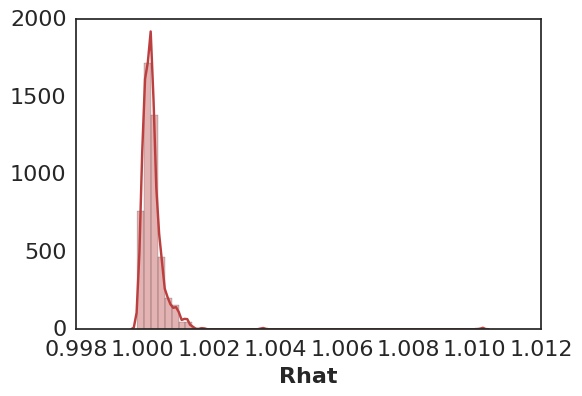

In [40]:
survivalstan.utils.plot_stan_summary([tcrclonality_by_pdl1_os], metric='Rhat')

{{{tcrclonality_by_pdl1_os}}}


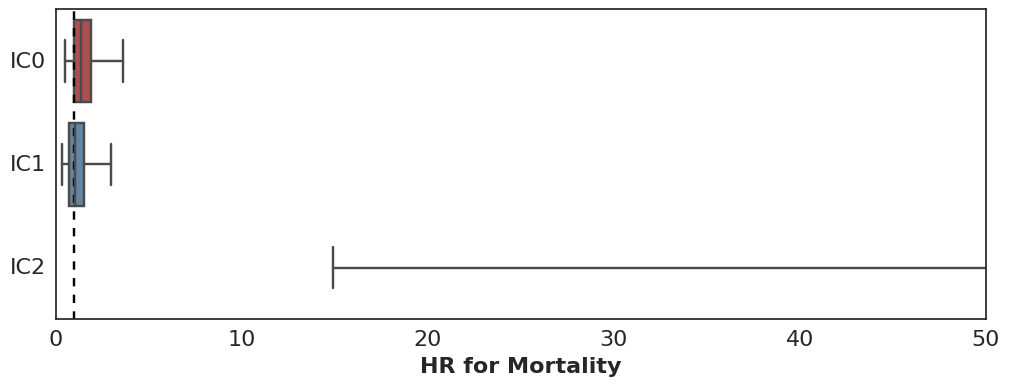

In [41]:
## capture current figure size
paper.hyper_figure_label_printer('tcrclonality_by_pdl1_os')
## make this plot much wider than usual
current_fig_size = plt.rcParams["figure.figsize"]
new_fig_size = [current_fig_size[0]*2, current_fig_size[1]]
plt.rcParams["figure.figsize"] = new_fig_size
## plot
sb.boxplot(data=tcrclonality_by_pdl1_os['grp_coefs'], x='exp(beta)', y='group', fliersize=0, whis=[2.5, 97.5])
_ = plt.xlim([0, 50])
_ = plt.ylabel('')
_ = plt.vlines(1, -10, 10, linestyles='--')
#_ = plt.title('Hazard associated with log(Peripheral clonality at timepoint A) \n by level of intratumoral PD-L1 expression')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))
## revert width to original size
plt.rcParams["figure.figsize"] = current_fig_size

{{{tcrclonality_by_pdl1_os_split}}}


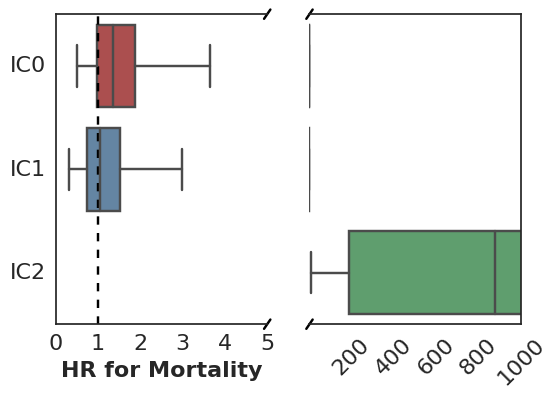

In [42]:
paper.hyper_figure_label_printer('tcrclonality_by_pdl1_os_split')
## plot side-by-side zoomed & unzoomed plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sb.boxplot(data=tcrclonality_by_pdl1_os['grp_coefs'],
           x='exp(beta)',
           y='group',
           fliersize=0,
           whis=[2.5, 97.5], 
           ax=ax1,
          )
ax1.set_xlim([0, 5.])
ax1.set_ylabel('')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax1.set_yticklabels([0,1,2],['','',''])
#ax1.vlines(1, -10, 10, linestyles='--')
#ax1.set_yticks([0])
#ax1.get_yaxis().set_visible(False)

sb.boxplot(data=tcrclonality_by_pdl1_os['grp_coefs'],
           x='exp(beta)',
           y='group',
           fliersize=0,
           whis=[2.5, 97.5],
           ax=ax2,
          )
ax2.set_xlim([5.7, 1000])
ax2.set_ylabel('')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-right diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal

ax1.vlines(1, -10, 10, linestyles='--')
ax1.set_xlabel('HR for {}'.format(cohort.hazard_os_plot_name))
ax2.set_xlabel('')
## rotate labels on x axis
_ = plt.setp(ax1.get_xticklabels(), rotation=0)
_ = plt.setp(ax2.get_xticklabels(), rotation=45)